In [2]:
##Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read CSV file
df = pd.read_csv('Resources/ECT_Data.csv', low_memory=False)
df[['SR Create TS', 'SR Close TS', 'Cust Contact TS']] = df[['SR Create TS', 'SR Close TS', 'Cust Contact TS']].astype('datetime64[ns]')
df

,OCPM #,Geo,Region,Country,Country ISO Code,Make/Miss,CROSS #,RCMS #,RETAIN #,Salesforce #,...,F5,F2B,F7,FTP,ea,9d,Agent Id,PREM IND,GA IND,VATS Ind
0,409PFTF,NaN,NaN,CANADA,CA,Make,BQJJFTS,0,0,0,...,0,0,0,0,0,0,C-PAXBUS,Non-Premier Account,0,N
1,409PTT2,NaN,NaN,UNITED STATES,US,Make,0,0,0,0,...,0,0,0,0,12/16/2019 10:24,12/18/2019 11:54,WEB,Non-Premier Account,0,N
2,409PVLD,NaN,NaN,UNITED STATES,US,Make,0,0,0,0,...,0,0,0,0,12/16/2019 16:32,12/18/2019 11:48,WEB,Non-Premier Account,0,N
3,409MSGV,NaN,NaN,UNITED STATES,US,Miss,409MSGV,0,0,0,...,0,0,0,0,12/5/2019 14:34,0,WEB,Non-Premier Account,0,N
4,409G9TD,NaN,NaN,UNITED STATES,US,Miss,409G9TD,0,0,0,...,0,0,0,0,11/5/2019 16:03,0,WEB,Non-Premier Account,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23558,409SC2W,NaN,NaN,UNITED STATES,US,Make,BQJF9GV,0,0,0,...,0,0,0,0,0,0,C-NUVDUS,Non-Premier Account,0,Y
23559,409QWNT,NaN,NaN,UNITED STATES,US,Miss,409QWNT,0,0,0,...,0,0,0,0,0,0,C-RATTUS,Non-Premier Account,0,Y
23560,409RTPK,NaN,NaN,CANADA,CA,Make,BQJFPPH,0,0,0,...,0,0,0,0,1/2/2020 15:05,1/3/2020 15:24,WEB,Non-Premier Account,0,Y
23561,409PP4V,NaN,NaN,UNITED STATES,US,Miss,BQJJG8L,0,0,0,...,0,0,0,0,0,12/17/2019 11:02,C-KKHKUS,Non-Premier Account,0,Y


In [4]:
#Create data frames split by years
combined_df = df
ytd_df = df[df['SR Close TS'] >= '2020-01-01']
prevy_df = df[df['SR Close TS'] < '2020-01-01']

In [5]:
#Create new data frames with columns we're interested in
combined_datetime_df = combined_df[['OCPM #', 'Make/Miss', 'SR Create TS', 'SR Close TS']]
ytd_datetime_df = ytd_df[['OCPM #', 'Make/Miss', 'SR Create TS', 'SR Close TS']]
prevy_datetime_df = prevy_df[['OCPM #', 'Make/Miss', 'SR Create TS', 'SR Close TS']]

#Create new columns with difference on data frames
combined_datetime_df['CX - RC'] = (combined_datetime_df['SR Close TS'] - combined_datetime_df['SR Create TS'])
ytd_datetime_df['CX - RC'] = (ytd_datetime_df['SR Close TS'] - ytd_datetime_df['SR Create TS'])
prevy_datetime_df['CX - RC'] = (prevy_datetime_df['SR Close TS'] - prevy_datetime_df['SR Create TS'])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [6]:
#Create groups
combined_make_miss_group = combined_datetime_df.groupby('Make/Miss')
ytd_make_miss_group = ytd_datetime_df.groupby('Make/Miss')
prevy_make_miss_group = prevy_datetime_df.groupby('Make/Miss')

## Perecentages by year

In [7]:
#New data frame for summary of Make/Miss percentages
percent_make_miss_df = pd.DataFrame({    
    '2020': ytd_make_miss_group['OCPM #'].count() * 100 / ytd_make_miss_group['OCPM #'].count().sum(),
    '2019': prevy_make_miss_group['OCPM #'].count() * 100 / prevy_make_miss_group['OCPM #'].count().sum(),
    'Combined': combined_make_miss_group['OCPM #'].count() * 100 / combined_make_miss_group['OCPM #'].count().sum(),
})

#Format columns with percentages
percent_make_miss_df['2020'] = percent_make_miss_df['2020'].map('{:.2f}%'.format)
percent_make_miss_df['2019'] = percent_make_miss_df['2019'].map('{:.2f}%'.format)
percent_make_miss_df['Combined'] = percent_make_miss_df['Combined'].map('{:.2f}%'.format)

#Display data frame
percent_make_miss_df

,2020,2019,Combined
Make/Miss,,,
Make,38.92%,34.41%,36.67%
Miss,61.08%,65.59%,63.33%


## Counts by year

In [8]:
#New data frame for counts
count_make_miss_df = pd.DataFrame({
    '2020 Count': ytd_make_miss_group['Make/Miss'].count(),    
    '2019 Count': prevy_make_miss_group['Make/Miss'].count(),
    'Combined Count': combined_make_miss_group['Make/Miss'].count()
})

#Display data frame
count_make_miss_df

,2020 Count,2019 Count,Combined Count
Make/Miss,,,
Make,4593,4048,8641
Miss,7207,7715,14922


## Stats by year

In [9]:
#Descriptive stats data frame

describe_df = pd.DataFrame({
    '2020': ytd_datetime_df['CX - RC'].describe(),
    '2019': prevy_datetime_df['CX - RC'].describe(),
    'Combined': combined_datetime_df['CX - RC'].describe()
})

describe_df

,2020,2019,Combined
count,11800,11763,23563
mean,13 days 03:56:23.532203,11 days 10:36:20.785513,12 days 07:18:18.988244
std,11 days 15:21:53.761626,9 days 18:08:31.262375,10 days 18:36:15.472835
min,0 days 00:01:00,0 days 00:02:00,0 days 00:01:00
25%,3 days 20:29:45,4 days 07:34:00,4 days 02:34:00
50%,9 days 23:12:30,8 days 00:54:00,8 days 10:18:00
75%,20 days 22:03:00,15 days 22:54:30,18 days 02:44:00
max,152 days 23:44:00,166 days 23:18:00,166 days 23:18:00


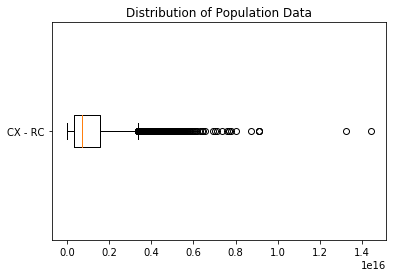

In [10]:
#Create box plots to visualize data
fig, ax = plt.subplots()
ax.set_title('Distribution of Population Data')
ax.boxplot(combined_datetime_df['CX - RC'], labels = ['CX - RC'], vert = False)
plt.show()